In [1]:
from main_experiment_256 import *
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (60, 20)
%matplotlib inline

In [2]:
import sklearn
import sklearn.decomposition

In [3]:
batch_size = 256

In [4]:
os.getcwd()

'/data/ssd/qingqiao/workspaces/slices-to-3d-brain-vae/experiments/MICCAI-release-version'

In [7]:
encoder = Encoder(1, gf_dim=4)
decoder = Decoder(1, gf_dim=4)

encoder = encoder.to(device())
decoder = decoder.to(device())
# change to your path, please
load_path = 'experiments/MICCAI-release-version/gen/vol_256_lr_0.0001_kl_0.01__bsize_32/checkpoints/model_00000300.pth.tar'

print('Cuda is {}available'.format('' if torch.cuda.is_available() else 'not '))

checkpoint = torch.load(load_path, map_location=device())
start_epoch = checkpoint['epoch']
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
step = checkpoint['step']
print("=> loaded")

# print(encoder)
# print(decoder)
encoder = encoder.to(device())
decoder = decoder.to(device())
# args = parser.parse_args()
train_loader = make_train_loader(batch_size=batch_size)
# test_loader = make_test_loader(batch_size=batch_size)


Cuda is available
=> loaded


usage: ipykernel_launcher.py [-h] [--batch-size N] [--epochs N] [--save_epoch_interval N] [--no-cuda] [--seed S]
                             [--log-interval N] [--latent-dimension N] [--n-channels N] [--img-size N]
                             [--learning-rate N] [--architecture N]
                             [--reconstruction-data-loss-weight RECONSTRUCTION_DATA_LOSS_WEIGHT]
                             [--kl-latent-loss-weight KL_LATENT_LOSS_WEIGHT] [--mri_data_dir MRI_DATA_DIR]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/qingqiao/.local/share/jupyter/runtime/kernel-ff409bb9-ff21-4999-a354-adc9f0a29d0b.json


SystemExit: 2

/home/qingqiao/anaconda3/envs/p2p-3d/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
def plot_sequence_coronal(data, K=10):
    plt.rcParams['figure.figsize'] = (30, 10)
    mask_ix = sorted(list(set(np.linspace(0, batch_size - 1, K).astype(np.int))))
    mask = [True if i in mask_ix else False for i in range(batch_size)]
    if type(data) is torch.Tensor:
        data = data.detach().numpy()
    for i, mix in enumerate(mask_ix):
        plt.subplot(1, K, i+1)
        plt.imshow(data[mix, 0, :, :].squeeze(), vmin=0.0, vmax=1.0, cmap='gray')
        plt.axis('off')
    plt.show()

In [7]:
def plot_sequence_sagittal(data, K=10):
    plt.rcParams['figure.figsize'] = (30, 10)
    mask_ix = sorted(list(set(np.linspace(0, batch_size - 1, K).astype(np.int))))
    mask = [True if i in mask_ix else False for i in range(batch_size)]
    if type(data) is torch.Tensor:
        data = data.detach().numpy()
    for i, mix in enumerate(mask_ix):
        plt.subplot(1, K, i+1)
        plt.imshow(data[:, 0, mix, :].squeeze(), vmin=0.0, vmax=1.0, cmap='gray')
        plt.axis('off')
    plt.show()

In [8]:
def plot_sequence_axial(data, K=10):
    plt.rcParams['figure.figsize'] = (30, 10)
    mask_ix = sorted(list(set(np.linspace(0, batch_size - 1, K).astype(np.int))))
    mask = [True if i in mask_ix else False for i in range(batch_size)]
    if type(data) is torch.Tensor:
        data = data.detach().numpy()
    for i, mix in enumerate(mask_ix):
        plt.subplot(1, K, i+1)
        plt.imshow(data[:, 0, :, mix].squeeze(), vmin=0.0, vmax=1.0, cmap='gray')
        plt.axis('off')
    plt.show()

In [9]:
AXIS=32
conv_h, conv_w = 2,2
latent_dimension = 8*32
img_size=256

In [10]:
N_train_ex = 400
N_test_ex=20
latents_train = np.zeros((N_train_ex, batch_size, latent_dimension, conv_h, conv_w))
images_test = np.zeros((N_test_ex, batch_size, img_size, img_size))
for i, (data, _) in enumerate(train_loader):
    data = data.to(device())
    if i == N_train_ex:
        break
    latent, mu, std = encoder(data)
    latents_train[i, ...] = mu.cpu().detach().numpy()
    if i < N_test_ex:
        images_test[i, ...] = data.cpu().squeeze().detach().numpy()

In [11]:
# N_test_ex = 20
# latents_test = np.zeros((N_test_ex, batch_size, latent_dimension, conv_h, conv_w))
# images_test = np.zeros((N_test_ex, batch_size, img_size, img_size))
# for i, (data, _) in enumerate(test_loader):
#     if i == N_test_ex:
#         break
#     data = data.to(device())
#     latent, mu, std  = encoder(data)
#     latents_test[i, ...] = mu.cpu().detach().numpy()
#     images_test[i, ...] = data.cpu().squeeze().detach().numpy()

In [12]:
latents_train.shape

(400, 256, 256, 2, 2)

In [13]:
def flatten_conv_map(latent):
    return latent.reshape([latent.shape[0], latent.shape[1], -1])

In [14]:
def unflatten_conv_map(flattened):
    return flattened.reshape([flattened.shape[0], flattened.shape[1], latent_dimension, conv_h, conv_w])

# Data

<ipython-input-6-2486c210339c>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_ix = sorted(list(set(np.linspace(0, batch_size - 1, K).astype(np.int))))


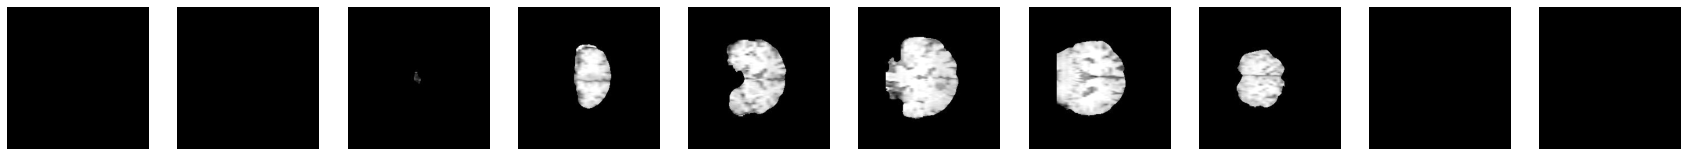

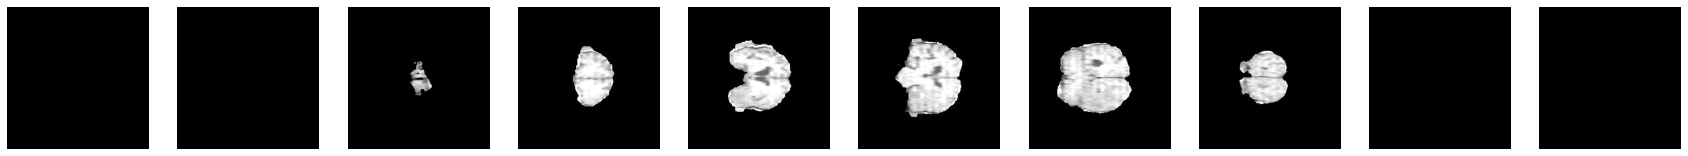

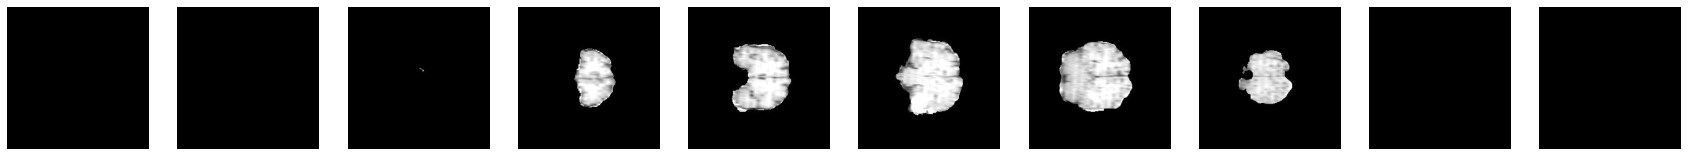

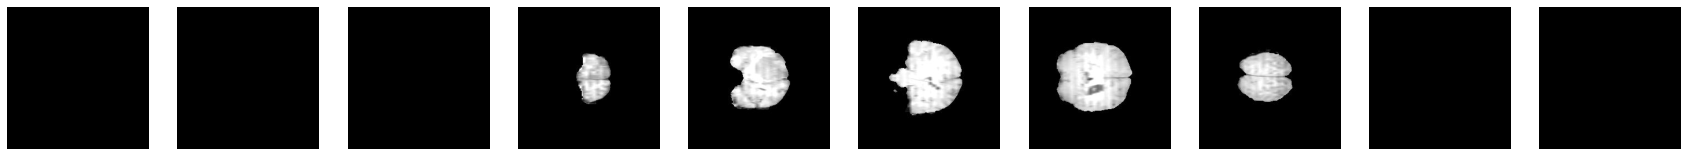

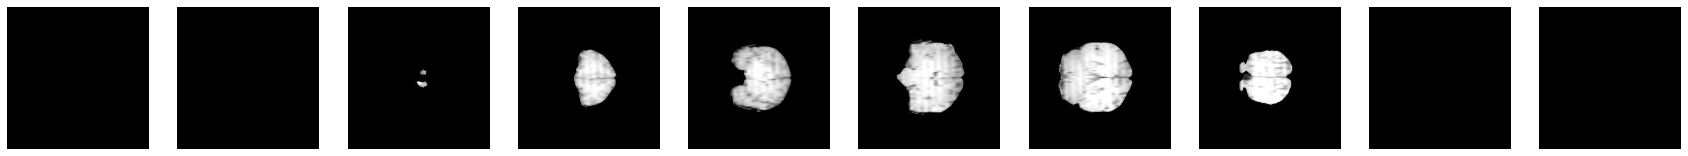

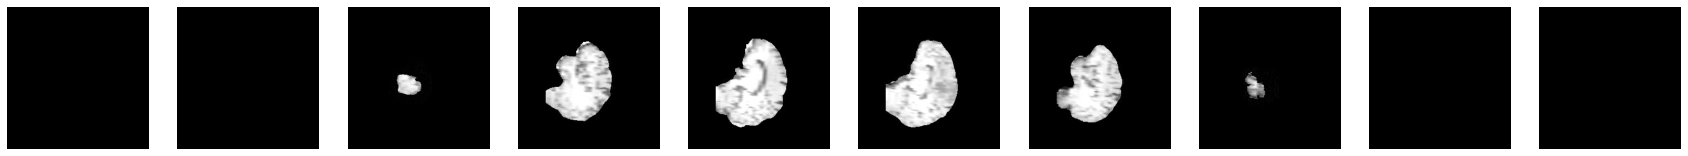

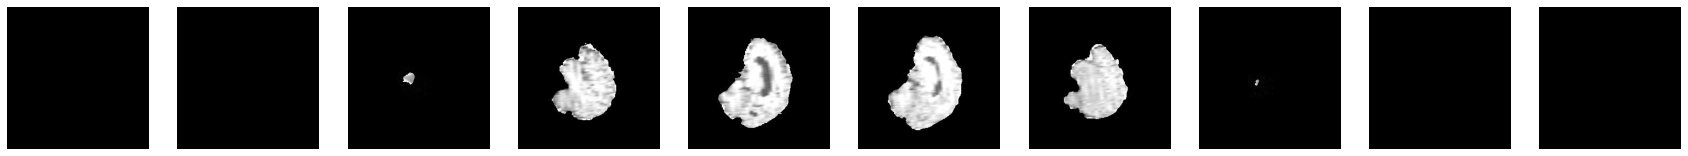

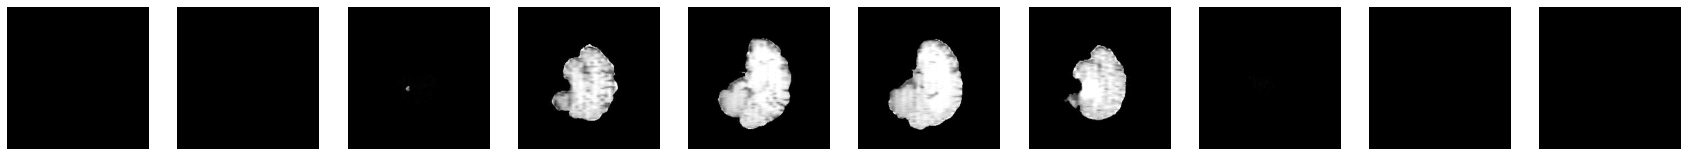

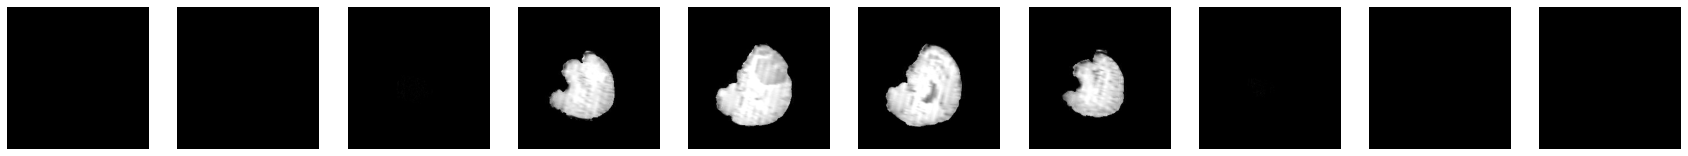

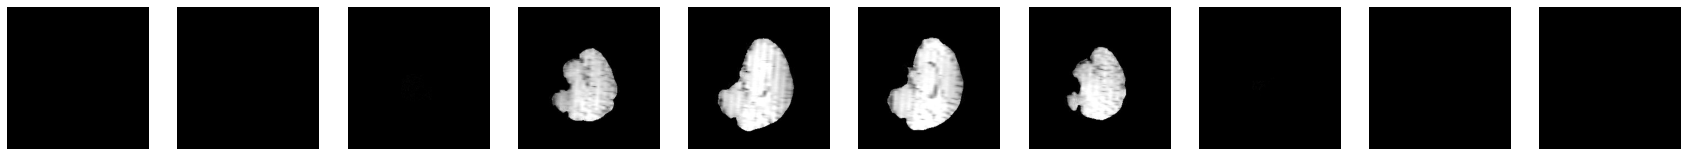

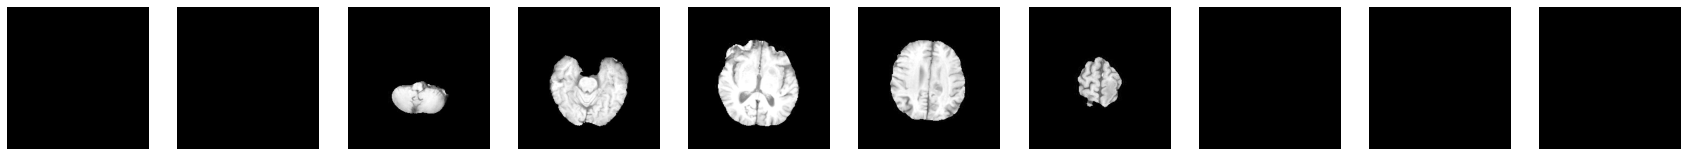

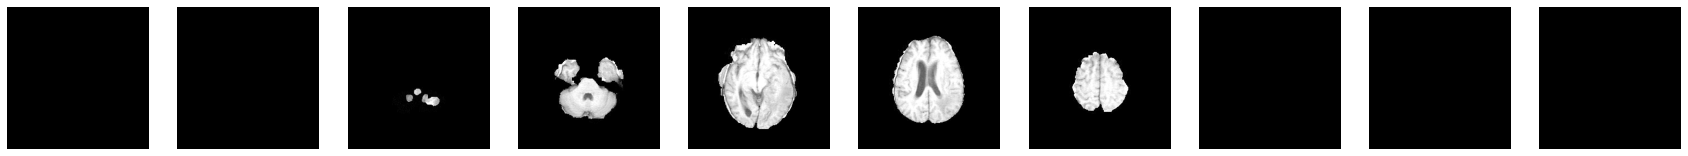

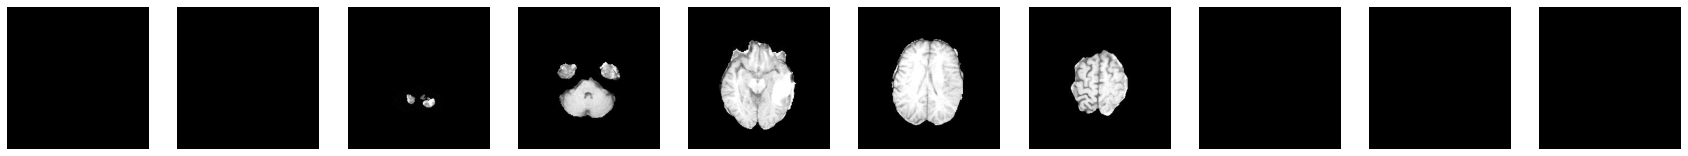

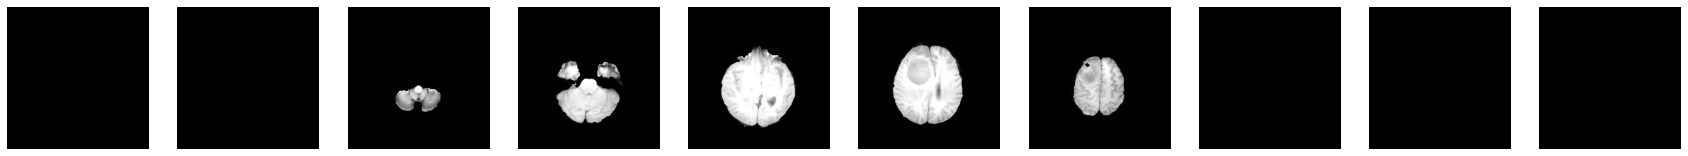

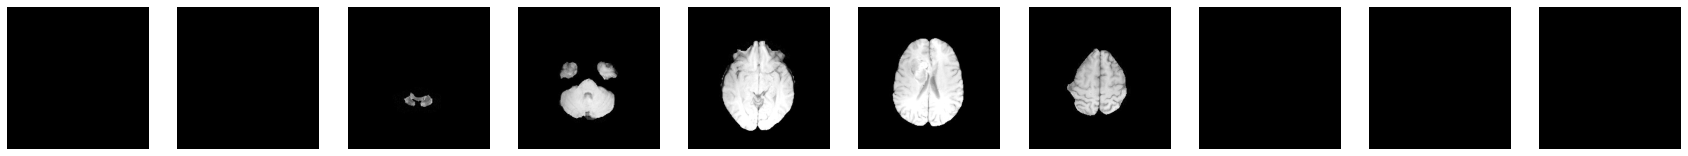

In [15]:
for i in range(5):
    images = images_test[i, :, None, :, :]
    plot_sequence_coronal(images, K=10)
print('='*80)
for i in range(5):
    images = images_test[i, :, None, :, :]
    plot_sequence_sagittal(images, K=10)
print('='*80)
for i in range(5):
    images = images_test[i, :, None, :, :]
    plot_sequence_axial(images, K=10)

# Samples from Gaussian Model

In [16]:
flattened_latents_train = flatten_conv_map(latents_train)
# flattened_latents_test = flatten_conv_map(latents_test)

mean = flattened_latents_train.transpose(-1, 0, 1).mean(axis=1, keepdims=True)
X = flattened_latents_train.transpose(-1, 0, 1) - mean
# X_test = flattened_latents_test.transpose(-1, 0, 1) - mean

u, s, vh = np.linalg.svd(X)


In [17]:
mean.shape

(1024, 1, 256)

<ipython-input-6-2486c210339c>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_ix = sorted(list(set(np.linspace(0, batch_size - 1, K).astype(np.int))))


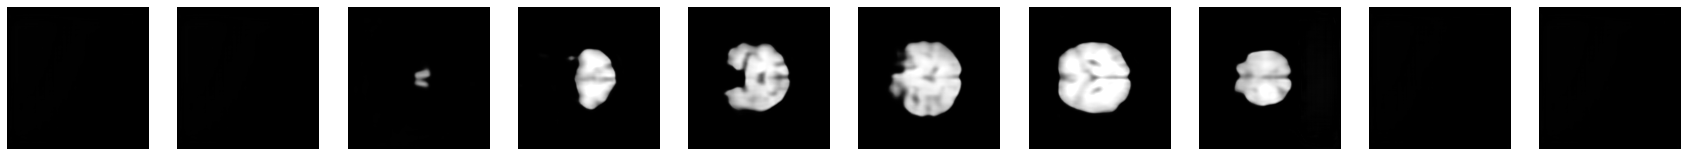

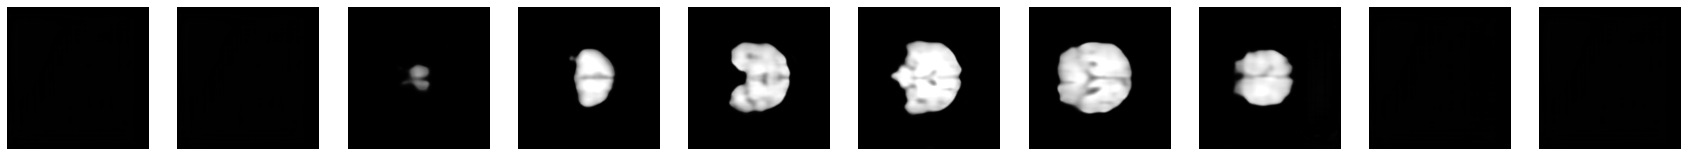

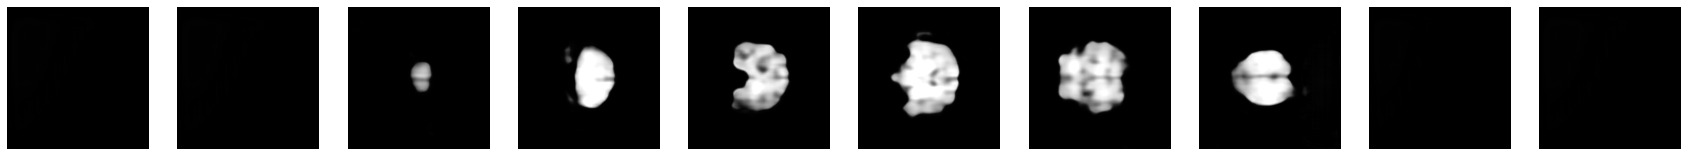

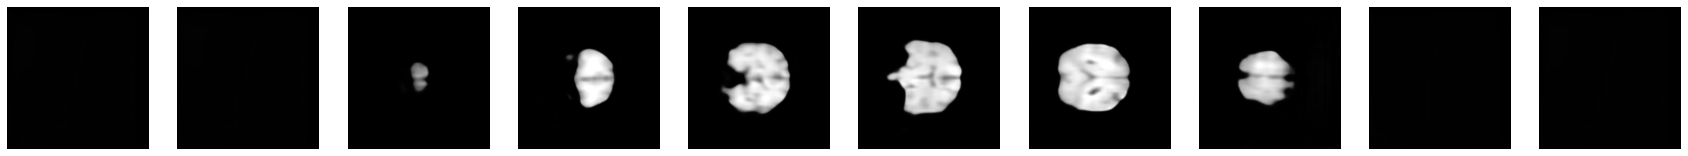

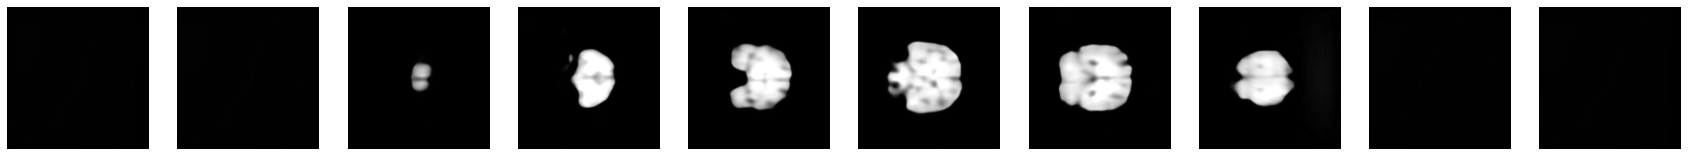

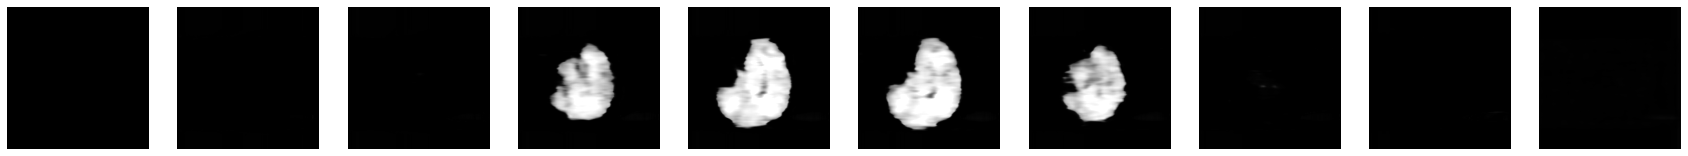

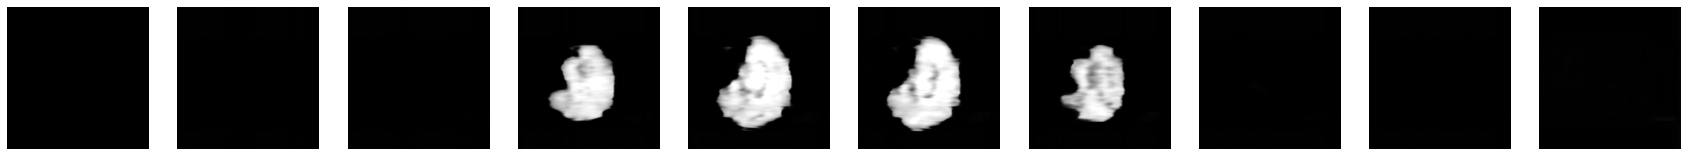

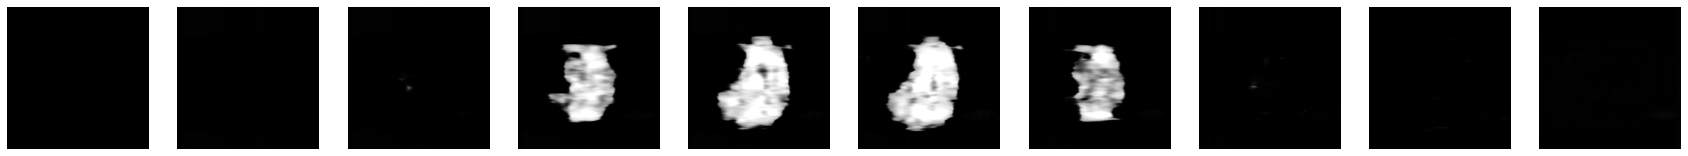

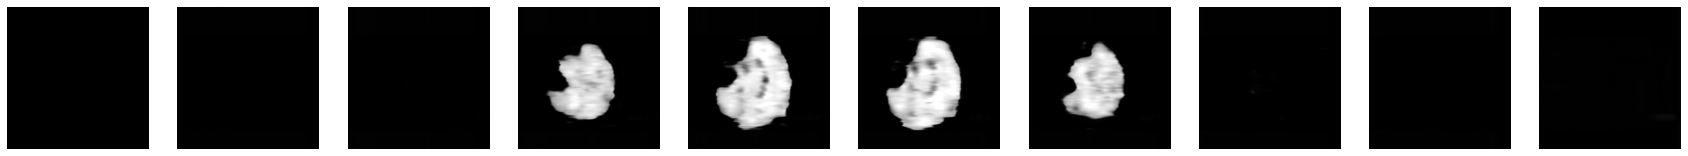

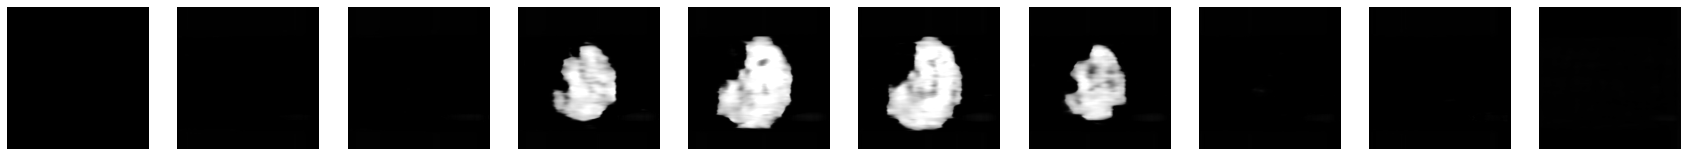

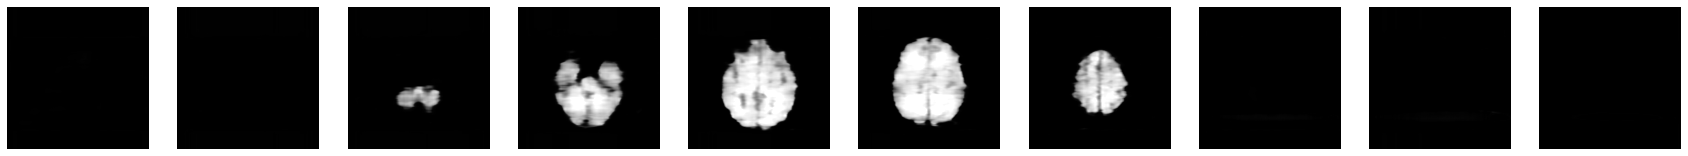

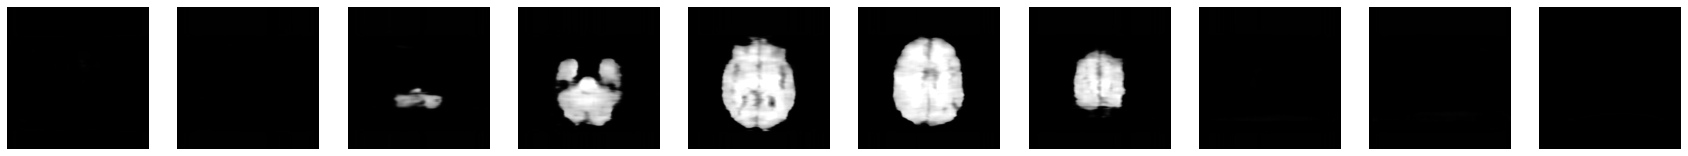

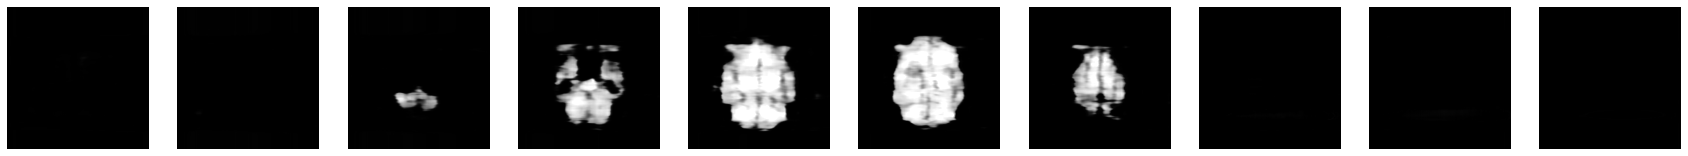

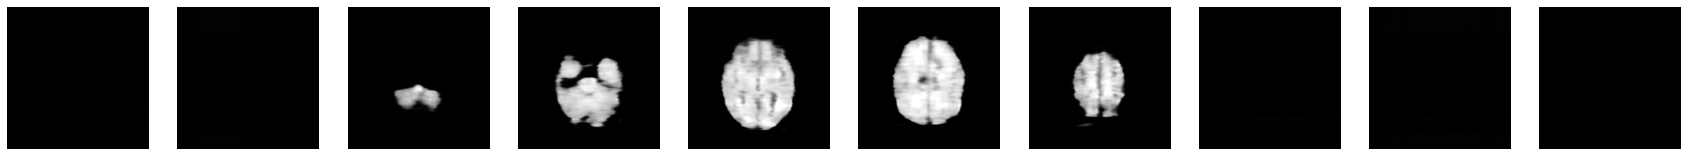

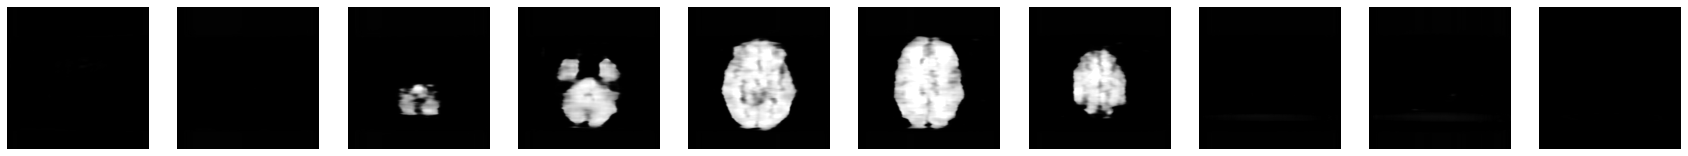

In [18]:
P = 64

# observed = (X_test.transpose([0, 2, 1])).transpose([0, 2, 1])

sdiaged = s[:, None, :P]*np.eye(P) / np.sqrt(N_train_ex)
A = np.matmul(vh.transpose([0, 2, 1])[:, :, :P], sdiaged)

z_gt = np.random.randn(latent_dimension*conv_h*conv_w, N_test_ex, P)
observed = (A @ z_gt.transpose([0, 2, 1])).transpose([0, 2, 1])

latent_recon = torch.Tensor(observed) + torch.Tensor(mean)
latent_recon = latent_recon.permute([1, 2, 0])
latent_recon = unflatten_conv_map(latent_recon)

samples = np.zeros(images_test[:, :, None, :, :].shape)

for i in range(5):
    images = decoder(latent_recon[i,...].to(device()))
    samples[i, ...] = images.detach().cpu().numpy()

for i in range(5):
    plot_sequence_coronal(samples[i, ...], K=10)
print('='*80)
for i in range(5):
    plot_sequence_sagittal(samples[i, ...], K=10)
print('='*80)
for i in range(5):
    plot_sequence_axial(samples[i, ...], K=10)



In [19]:
with open('/data/ssd/qingqiao/workspaces/3D-MRI-style-transfer/vae_checkpoints/CBICA2TCIA/W.npy', 'wb') as f:
    np.save(f, A)
with open('/data/ssd/qingqiao/workspaces/3D-MRI-style-transfer/vae_checkpoints/CBICA2TCIA/mean.npy', 'wb') as f:
    np.save(f, mean)

In [20]:
def sample_volumes_minus1_1():
    '''samples volumes. volumes are normalized to be in the -1 to 1 range'''
    z_gt = np.random.randn(latent_dimension*conv_h*conv_w, 1, P)*1
    
    observed = (A @ z_gt.transpose([0, 2, 1])).transpose([0, 2, 1])
    latent_recon = torch.Tensor(observed) + torch.Tensor(mean)
    latent_recon = latent_recon.permute([1, 2, 0])
    latent_recon = unflatten_conv_map(latent_recon)

    images = decoder(latent_recon[0,...].to(device()))
    images[images<0] = 0
    images[images>1] = 1
    images = 2*images -1

    return images.detach().cpu().numpy().squeeze()[None, ...]

In [21]:
np.random.seed(2020)
torch.manual_seed(2020)

# MS-SSIM

You could compute MS-SSIM here on pairs of real-generated images

# MMD

In [22]:
def sample_volumes_4batch():
    z_gt = np.random.randn(latent_dimension*conv_h*conv_w, 4, P)*1

    observed = (A @ z_gt.transpose([0, 2, 1])).transpose([0, 2, 1])
    latent_recon = torch.Tensor(observed) + torch.Tensor(mean)
    latent_recon = latent_recon.permute([1, 2, 0])
    latent_recon = unflatten_conv_map(latent_recon)
    images = torch.zeros(4, 1, 256, 256, 256)
    for i in range(4):
        images[i, 0, ...] = decoder(latent_recon[i,...].to(device())).detach().cpu().squeeze()[None, ...]
    images[images<0] = 0
    images[images>1] = 1
    images = 2*images -1
    return images


You could compute MMD here on batches of 4 volumes (not 8 as in other sizes, because 256^3 are very large in memory and I could only fit 4)

In [23]:
np.random.seed(2020)
torch.manual_seed(2020)
import nibabel as nib

In [24]:
def sample_volumes():
    '''samples volumes. volumes are normalized to be in the 0 to 1 range'''
    z_gt = np.random.randn(latent_dimension*conv_h*conv_w, 1, P)*1
    
    observed = (A @ z_gt.transpose([0, 2, 1])).transpose([0, 2, 1])
    latent_recon = torch.Tensor(observed) + torch.Tensor(mean)
    latent_recon = latent_recon.permute([1, 2, 0])
    latent_recon = unflatten_conv_map(latent_recon)

    images = decoder(latent_recon[0,...].to(device()))
    images[images<0] = 0
    images[images>1] = 1

    return images.detach().cpu().numpy().squeeze()[None, ...]

In [25]:
def save_nii(img_path, data, affine, header=None):
    '''
    Shortcut to save a nifty file
    '''
    if header == None:
        nimg = nib.Nifti1Image(data, affine=affine)
    else:
        nimg = nib.Nifti1Image(data, affine=affine, header=header)
    nimg.to_filename(img_path)

In [ ]:
save_dir = 'path/to/saving/volumes/256'
method = 'ours'
methoddir = os.path.join(save_dir, method)
os.makedirs(methoddir, exist_ok=True)
for i in range(100):
    print(i)
    data = sample_volumes().squeeze()
    assert data.min() >= 0.0
    assert data.max() <= 1.0
    img_path = os.path.join(methoddir, 'images_{0:06d}.nii'.format(i))
    save_nii(img_path, data, np.eye(4), header=None)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
